In [57]:
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [58]:
from matplotlib import font_manager, rc
import matplotlib
import platform

# 한글꺠짐 처리(windows, mac)
path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")
    
# 차트에 마이너스 부분이 깨질때 처리
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [59]:
import matplotlib.pyplot as plt
# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당합니다.

# ggplot으로 그래프 스타일 설정
plt.style.use('ggplot')

# 그래프에 retina display 적용
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# set_matplotlib_formats('png')
# set_matplotlib_formats('jpg')
# set_matplotlib_formats('svg')

### 데이터 불러오기

In [60]:
train = pd.read_csv('./Data/train_df_errno_final.csv')
test = pd.read_csv('./Data/test_df_final.csv')

train_ml = pd.read_csv('./Data/train_df_errno_final(ML).csv')
test_ml = pd.read_csv('./Data/test_df_final(ML).csv')

age = pd.read_csv('./Data/age_gender_info.csv')

train.shape, test.shape, train_ml.shape, test_ml.shape

((2896, 23), (1008, 21), (2896, 23), (1008, 21))

In [61]:
# stat.molit.go.kr/portal/cate/statFileView.do?hRsId=58&hFormId=5409&hKeyWord=자동차등록&hTotalFlag=Y
car = pd.read_excel('./Data/2021년_06월_자동차_등록자료_통계.xlsx', 
                    sheet_name=3,
                    skiprows=2,
                    usecols=range(0, 20))
car.shape

(22, 20)

In [62]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,단지내주차면수,단지코드_Type,임대건물구분_lbl,지역_lbl,공급유형_lbl,자격유형_lbl,단지코드_lbl,qcut_총세대수,등록차량수,log_등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876


In [63]:
age.head()

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


### 자동차 등록자료 결측치 및 데이터 전처리

In [64]:
car

,성별,연령/시도,총계,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주
0,남성,10대 이하,7437,1371,446,198,389,153,276,189,75,2140,181,267,277,294,280,184,564,153
1,NaN,20대,356992,34205,18101,16904,22269,12628,12114,8930,2209,97857,14409,16590,20507,14402,15546,20746,24485,5090
2,NaN,30대,2159536,302499,118012,101979,127869,63873,66700,53399,22189,629142,63712,77251,111205,67031,70872,112663,143393,27747
3,NaN,40대,3912264,508214,211040,189715,215684,117530,113270,99745,42365,1109019,118716,132873,197513,142332,145890,221831,286281,60246
4,NaN,50대,4417099,535067,225506,226919,231824,130177,129276,126736,31715,1138075,156776,167229,219242,183433,203100,300922,341419,69683
5,NaN,60대,3450897,433997,203219,172957,173957,84641,96344,97069,19851,788009,142611,141150,177831,152936,166940,272794,277696,48895
6,NaN,70대,1088779,158200,67062,55435,44577,26622,28079,23543,5163,217137,47229,42168,60042,55916,62158,94595,83319,17534
7,NaN,80대,193790,30506,10403,9524,6641,4423,4795,2808,837,41212,10213,7868,11054,10473,10352,16589,12406,3686
8,NaN,90대 이상,16671,3403,1012,746,627,382,384,222,65,3482,658,504,859,957,978,1165,971,256
9,NaN,계,15603465,2007462,854801,774377,823837,440429,451238,412641,124469,4026073,554505,585900,798530,627774,676116,1041489,1170534,233290


In [65]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   성별      4 non-null      object
 1   연령/시도   21 non-null     object
 2   총계      22 non-null     int64 
 3   서울      22 non-null     int64 
 4   부산      22 non-null     int64 
 5   대구      22 non-null     int64 
 6   인천      22 non-null     int64 
 7   광주      22 non-null     int64 
 8   대전      22 non-null     int64 
 9   울산      22 non-null     int64 
 10  세종      22 non-null     int64 
 11  경기      22 non-null     int64 
 12  강원      22 non-null     int64 
 13  충북      22 non-null     int64 
 14  충남      22 non-null     int64 
 15  전북      22 non-null     int64 
 16  전남      22 non-null     int64 
 17  경북      22 non-null     int64 
 18  경남      22 non-null     int64 
 19  제주      22 non-null     int64 
dtypes: int64(18), object(2)
memory usage: 3.6+ KB


In [66]:
car.isna().sum()

성별       18
연령/시도     1
총계        0
서울        0
부산        0
대구        0
인천        0
광주        0
대전        0
울산        0
세종        0
경기        0
강원        0
충북        0
충남        0
전북        0
전남        0
경북        0
경남        0
제주        0
dtype: int64

In [67]:
car.iloc[1:10, 0] = '남성'
car.iloc[11:20, 0] = '여성'
car.iloc[21, 1] = '합계'

In [68]:
car.isna().sum()

성별       0
연령/시도    0
총계       0
서울       0
부산       0
대구       0
인천       0
광주       0
대전       0
울산       0
세종       0
경기       0
강원       0
충북       0
충남       0
전북       0
전남       0
경북       0
경남       0
제주       0
dtype: int64

In [69]:
car.columns = ['성별', '연령', '총계', '서울특별시', '부산광역시', 
               '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
               '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도',
               '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']
car.columns

Index(['성별', '연령', '총계', '서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시',
       '울산광역시', '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도',
       '경상북도', '경상남도', '제주특별자치도'],
      dtype='object')

### 성별/연령별 자동차 등록대수 시각화

In [70]:
car

,성별,연령,총계,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
0,남성,10대 이하,7437,1371,446,198,389,153,276,189,75,2140,181,267,277,294,280,184,564,153
1,남성,20대,356992,34205,18101,16904,22269,12628,12114,8930,2209,97857,14409,16590,20507,14402,15546,20746,24485,5090
2,남성,30대,2159536,302499,118012,101979,127869,63873,66700,53399,22189,629142,63712,77251,111205,67031,70872,112663,143393,27747
3,남성,40대,3912264,508214,211040,189715,215684,117530,113270,99745,42365,1109019,118716,132873,197513,142332,145890,221831,286281,60246
4,남성,50대,4417099,535067,225506,226919,231824,130177,129276,126736,31715,1138075,156776,167229,219242,183433,203100,300922,341419,69683
5,남성,60대,3450897,433997,203219,172957,173957,84641,96344,97069,19851,788009,142611,141150,177831,152936,166940,272794,277696,48895
6,남성,70대,1088779,158200,67062,55435,44577,26622,28079,23543,5163,217137,47229,42168,60042,55916,62158,94595,83319,17534
7,남성,80대,193790,30506,10403,9524,6641,4423,4795,2808,837,41212,10213,7868,11054,10473,10352,16589,12406,3686
8,남성,90대 이상,16671,3403,1012,746,627,382,384,222,65,3482,658,504,859,957,978,1165,971,256
9,남성,계,15603465,2007462,854801,774377,823837,440429,451238,412641,124469,4026073,554505,585900,798530,627774,676116,1041489,1170534,233290


In [71]:
car['성별연령'] = car['성별'] + ' ' + car['연령']

In [72]:
grap_car = car.drop([9, 19, 20, 21])

In [73]:
grap_car.columns[3:-1]

Index(['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
       '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도',
       '제주특별자치도'],
      dtype='object')

Text(0, 0.5, '자동차 등록대수')

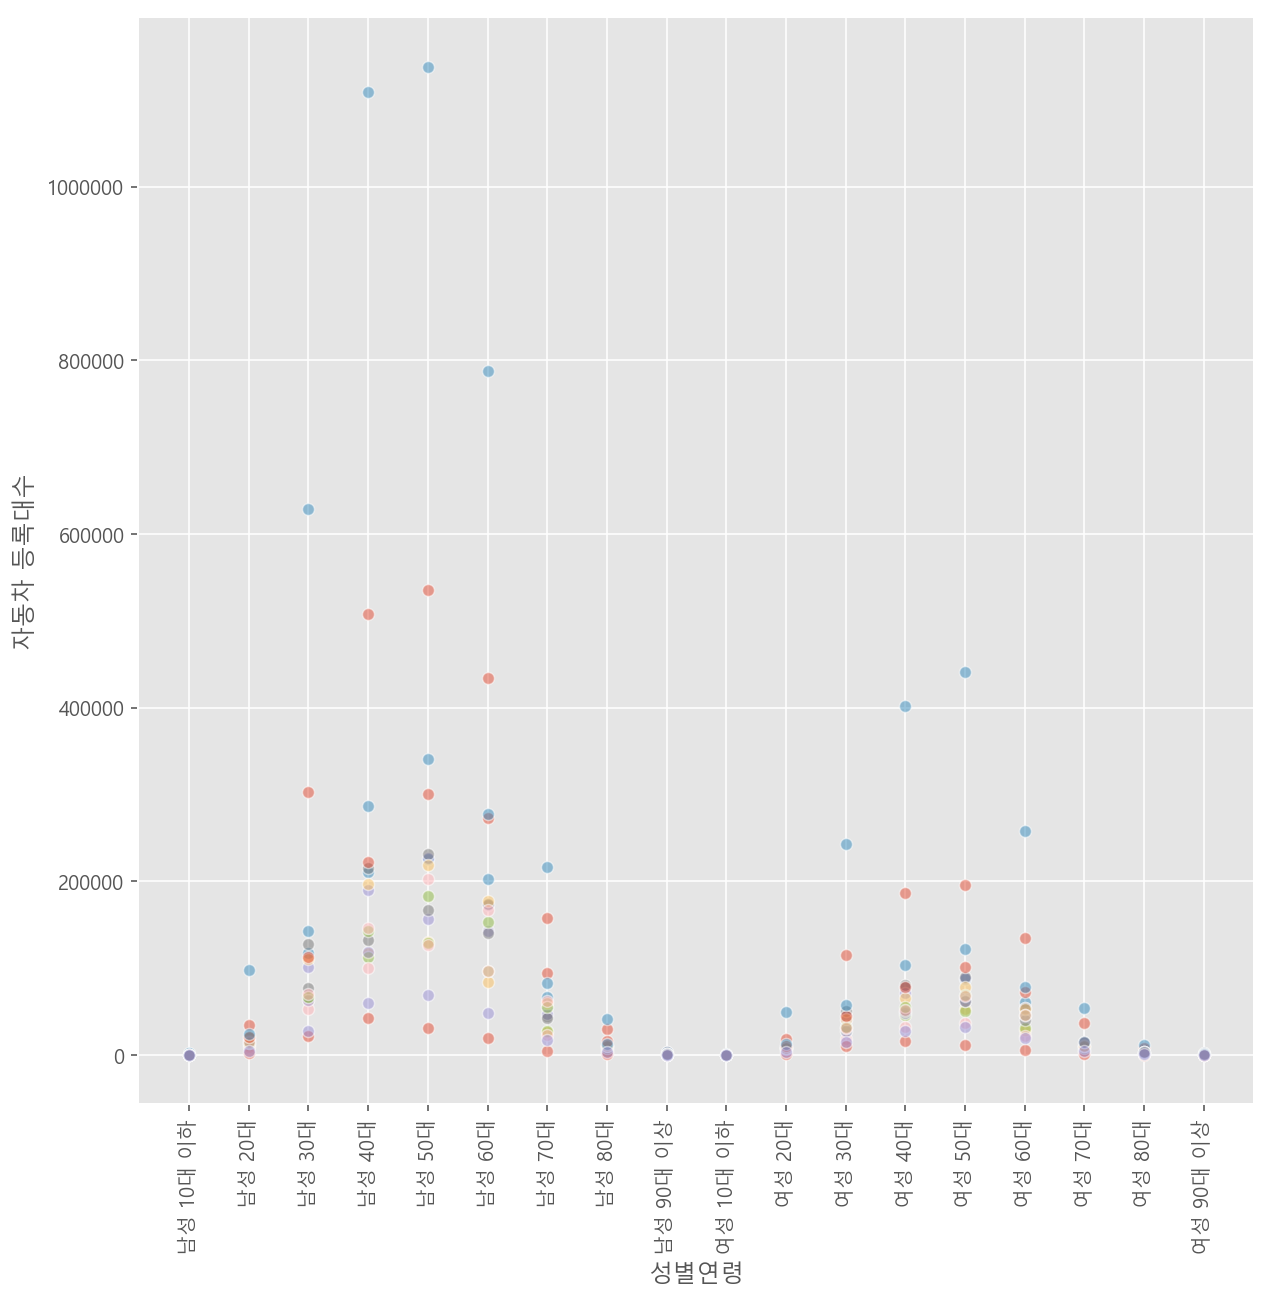

In [74]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation = 90 )

for i in grap_car.columns[3:-1] :
    sns.lineplot(x='성별연령', y=i, data=grap_car, marker='o', linestyle = "none", alpha=0.5)
    
plt.ylabel("자동차 등록대수")

In [75]:
grouped = grap_car.groupby('연령')

group = grouped.sum()

Text(0, 0.5, '남녀 자동차 등록대수')

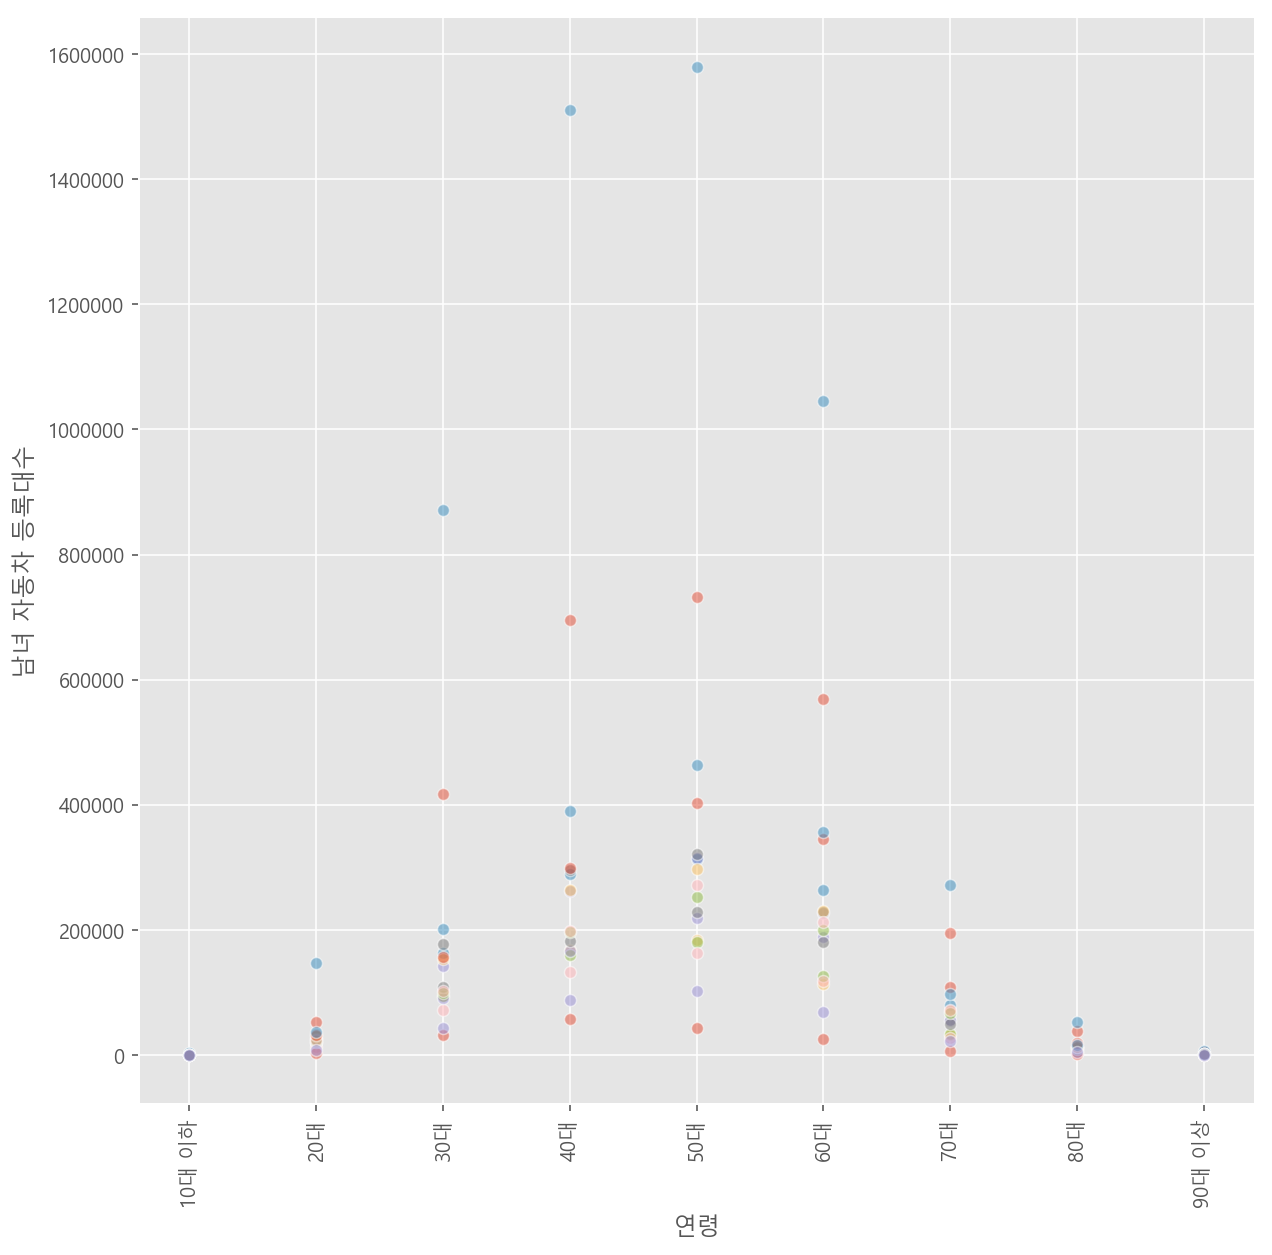

In [76]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation = 90 )

for i in grap_car.columns[3:-1] :
    sns.lineplot(x='연령', y=i, data=group, marker='o', linestyle = "none", alpha=0.5)
    
plt.ylabel("남녀 자동차 등록대수")

### 20 ~ 70대 임대주택 인구 비율 합산
- 20 ~ 70대의 자동차 등록비율이 높았기때문에

In [77]:
age.head(2)

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010


In [78]:
age['20~70대'] = age.iloc[:, 5:17].sum(axis=1)
age

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),20~70대
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.770990
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,0.792032
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066,0.804626
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067,0.770983
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013,0.766098
5,강원도,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,...,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017,0.780250
6,광주광역시,0.031994,0.034566,0.049851,0.050254,0.065084,0.066875,0.066888,0.064416,0.080028,...,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013,0.785641
7,충청남도,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,...,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123,0.772687
8,부산광역시,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,...,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028,0.808142
9,제주특별자치도,0.034690,0.036695,0.060094,0.063080,0.069135,0.069667,0.050808,0.048026,0.080548,...,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082,0.759010


### Feature 추가(단지당 자동차 보유 가능 인구비율)
- 예측 feature 1 : 단지당 운전가능 인구수 구하기
    - 가설 : 자동차 보유 인구를 20대에서 70대로 가정하며, 해당 인구는 자신에게 등록된 차량이 모두 있다고 가정한다.
    - 공식 : 지역별 자동차 보유 가능 연령비율 / 지역별 총 세대수 * 단지별 세대수

In [79]:
all_df = pd.concat([train, test], ignore_index=True)
all_df.shape

(3904, 23)

In [80]:
def car_calc(data) :
    loc = data['지역']
    
    total_house = group.loc[loc, '총세대수'].sum()
    loc_house = data['총세대수']
    popul = age.loc[ age['지역'] == loc, '20~70대' ].values[0]
    
    result = (popul / total_house) * loc_house
    
    return result

In [81]:
grouped = all_df.groupby(['지역', '단지코드'])
group = grouped.mean()

all_df['단지당 자동차 보유 가능 인구비율'] = all_df.apply(car_calc, axis=1)

In [82]:
all_df

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,단지코드_Type,임대건물구분_lbl,지역_lbl,공급유형_lbl,자격유형_lbl,단지코드_lbl,qcut_총세대수,등록차량수,log_등록차량수,단지당 자동차 보유 가능 인구비율
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,C1267,675,아파트,경상남도,행복주택,36.77,126,38.0,L,0.0,...,1.0,1,1,9,12,86,2,NaN,NaN,0.011304
3900,C2189,382,아파트,전라북도,국민임대,29.19,96,45.0,H,6872000.0,...,1.0,1,4,1,8,381,0,NaN,NaN,0.016835
3901,C2189,382,아파트,전라북도,국민임대,29.19,20,45.0,H,6872000.0,...,1.0,1,4,1,8,381,0,NaN,NaN,0.016835
3902,C2189,382,아파트,전라북도,국민임대,39.45,202,45.0,H,13410000.0,...,1.0,1,4,1,8,381,0,NaN,NaN,0.016835


In [83]:
train = all_df.iloc[0:2896,:]
test = all_df.iloc[2896:,:]

test.drop(['등록차량수', 'log_등록차량수'], inplace=True, axis=1)

train.shape, test.shape

C:\Users\Su\Anaconda3\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((2896, 24), (1008, 22))

### Feature 추가(교통편의성 / 총세대수주차면수)

In [84]:
train['교통편의성'] = train['10분내지하철수'] + train['10분내버스정류장수']
train['총세대수주차면수'] =  train['단지내주차면수'] / train['총세대수']

test['교통편의성'] = test['10분내지하철수'] + test['10분내버스정류장수']
test['총세대수주차면수'] =  test['단지내주차면수'] / test['총세대수']

C:\Users\Su\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Su\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Su\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

### Feature 별 상관관계 분석

In [85]:
train.corr()['log_등록차량수'].sort_values()

임대건물구분_lbl           -0.596565
공급유형_lbl             -0.291515
자격유형_lbl             -0.239157
10분내지하철수             -0.153996
단지코드_lbl             -0.065896
교통편의성                 0.053589
10분내버스정류장수            0.080114
단지코드_Type             0.093261
지역_lbl                0.108532
전용면적                  0.111644
단지당 자동차 보유 가능 인구비율    0.174055
공가수                   0.200793
총세대수                  0.228964
전용면적별세대수              0.274772
qcut_총세대수             0.303550
임대보증금                 0.458732
임대료                   0.557954
총세대수주차면수              0.735821
단지내주차면수               0.805096
등록차량수                 0.881679
log_등록차량수             1.000000
Name: log_등록차량수, dtype: float64

In [86]:
train_ml.corr()['등록차량수'].sort_values()

임대건물구분_lbl   -0.449130
자격유형_lbl     -0.154482
공급유형_lbl     -0.137277
10분내지하철수     -0.127452
단지코드_lbl     -0.062077
지역_lbl        0.060674
10분내버스정류장수    0.104189
단지코드_Type     0.109893
전용면적          0.112717
공가수           0.118910
전용면적별세대수      0.250513
총세대수          0.333440
qcut_총세대수     0.401309
임대료           0.435258
임대보증금         0.439936
단지내주차면수       0.861338
log_등록차량수     0.881679
등록차량수         1.000000
Name: 등록차량수, dtype: float64

In [87]:
# train[]

### 모델데이터 생성

In [88]:
# imp = model.feature_importances_                   # feature의 중요도
# n_features = len(sel)
# feature_names = sel
# plt.figure(figsize=(12,6))
# plt.barh(range(n_features) , imp, align='center')  # 그래프(가로 막대 그래프)
# plt.yticks(np.arange(n_features), feature_names)   # y축 값 지정
# plt.xlabel("feature importance")
# plt.ylabel("feature")
# plt.ylim(-1, n_features)

### Feature 중요도 확인

In [89]:
def plot_feature_important_common(model, col_names):
    imp = model.feature_importances_                   # feature의 중요도
    n_features = len(col_names)
    feature_names = col_names
    plt.barh(range(n_features) , imp, align='center')  # 그래프(가로 막대 그래프)
    plt.yticks(np.arange(n_features), feature_names)   # y축 값 지정
    plt.xlabel("feature importance")
    plt.ylabel("feature")
    plt.ylim(-1, n_features)

In [90]:
def model_catboost_score(sel, train, test) :
    
    X = train[sel]
    y = train['log_등록차량수']
    test_X = test[sel]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

    model.fit(X_train, y_train)
    
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    
    now_time = time.time()

    score = cross_val_score(model, X_train, y_train,
                            cv=5, scoring="neg_mean_absolute_error") # neg_mean_squared_error
    m_score = np.abs(score.mean())

    pro_time = time.time() - now_time
    print('Time :', pro_time)  # 걸린 시간
        
    print('Train :', train_score)
    print('Test :', test_score)
    print("CatBoostRegressor Score : {}".format(m_score))  # 점수
    
    plot_feature_important_common(model, sel)


1. '총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '임대건물구분_lbl', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수'
  - 0
    - Train : 0.969667933141996
    - Test : 0.9556545860859712
    - MAE : 0.10894951897736851
  - ML
    - Train : 0.9650052334394816
    - Test : 0.952464735797971
    - MAE : 0.1155802513018647
2. '총세대수', '전용면적', '전용면적별세대수', '공가수', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '임대건물구분_lbl', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수'
  - 임대료, 임대보증금이 정말 영향이 있을까 싶어서 제거해보았음
    - Train : 0.9659899308941171
    - Test : 0.9604956187319048
    - CatBoostRegressor Score : 0.1043724049246422
3. '총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '임대건물구분_lbl', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수'
  - 0
    - Train : 0.969667933141996
    - Test : 0.9556545860859712
    - CatBoostRegressor Score : 0.10894951897736851
  - ML
    - Train : 0.9621797461108202
    - Test : 0.9544715446593343
    - CatBoostRegressor Score : 0.11546486789673563
    2. '총세대수', '전용면적', '전용면적별세대수', '공가수', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
4. '총세대수', '전용면적', '전용면적별세대수', '공가수', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '임대건물구분_lbl', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수', '교통편의성', '총세대수주차면수'
  - Train : 0.9691612160338604
  - Test : 0.9550798483985361
  - CatBoostRegressor Score : 0.10306740764454218
5. '총세대수', '전용면적', '전용면적별세대수', '공가수', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수', '교통편의성', '총세대수주차면수'
  - Train : 0.9642501969559543
  - Test : 0.9549268671295694
  - CatBoostRegressor Score : 0.10058613391437125
6. '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
'10분내버스정류장수', '10분내지하철수', '임대건물구분_lbl', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
'교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
  - Train : 0.9636703246834547
  - Test : 0.957921832563748
  - CatBoostRegressor Score : 0.10093651220804309
7. '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
'10분내버스정류장수', '10분내지하철수', '임대건물구분_lbl', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
'교통편의성','총세대수주차면수','임대료','임대보증금'
  - Train : 0.9689002063896195
  - Test : 0.9572092497188488
  - CatBoostRegressor Score : 0.10434721441993702
8. '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
'10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
'교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
  - Train : 0.9660290240496178
  - Test : 0.9582228452461531
  - CatBoostRegressor Score : 0.09814497306425582

In [91]:
# 8 / 7
0.09814497306425582 > 0.10434721441993702

False

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   단지코드                2896 non-null   object 
 1   총세대수                2896 non-null   int64  
 2   임대건물구분              2896 non-null   object 
 3   지역                  2896 non-null   object 
 4   공급유형                2896 non-null   object 
 5   전용면적                2896 non-null   float64
 6   전용면적별세대수            2896 non-null   int64  
 7   공가수                 2896 non-null   float64
 8   자격유형                2896 non-null   object 
 9   임대보증금               2896 non-null   float64
 10  임대료                 2896 non-null   float64
 11  10분내지하철수            2896 non-null   float64
 12  10분내버스정류장수          2896 non-null   float64
 13  단지내주차면수             2896 non-null   float64
 14  단지코드_Type           2896 non-null   float64
 15  임대건물구분_lbl          2896 non-null   int64  
 16  지역_lbl

In [93]:
train_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   단지코드        2896 non-null   object 
 1   총세대수        2896 non-null   int64  
 2   임대건물구분      2896 non-null   object 
 3   지역          2896 non-null   object 
 4   공급유형        2896 non-null   object 
 5   전용면적        2896 non-null   float64
 6   전용면적별세대수    2896 non-null   int64  
 7   공가수         2896 non-null   float64
 8   자격유형        2896 non-null   object 
 9   임대보증금       2896 non-null   int64  
 10  임대료         2896 non-null   int64  
 11  10분내지하철수    2896 non-null   float64
 12  10분내버스정류장수  2896 non-null   float64
 13  단지내주차면수     2896 non-null   float64
 14  단지코드_Type   2896 non-null   float64
 15  임대건물구분_lbl  2896 non-null   int64  
 16  지역_lbl      2896 non-null   int64  
 17  공급유형_lbl    2896 non-null   int64  
 18  자격유형_lbl    2896 non-null   int64  
 19  단지코드_lbl    2896 non-null  

In [94]:
sel = ['총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
'10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
'교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율']

X = train[sel]*.
y = train['등록차량수']
test_X = test[sel]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

SyntaxError: invalid syntax (<ipython-input-94-50aa43e6fa41>, line 5)

In [ ]:
model_catboost_score(sel, train, test)
# model_catboost_score(sel, train_ml, test_ml)

Train : 0.9689002063896195
Test : 0.9572092497188488
CatBoostRegressor Score : 0.10434721441993702

Train : 0.9689002063896195
Test : 0.9572092497188488
CatBoostRegressor Score : 0.10434721441993702

In [ ]:
10434721441993702 == 10434721441993702

### cross_val_score 이용 사전 MAE 점수확인

In [ ]:
model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

model.fit(X_train, y_train)

print('Train :', model.score(X_train,y_train))
print('Test :', model.score(X_test,y_test))

In [ ]:
now_time = time.time()

model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

model.fit(X_train, y_train)

score = cross_val_score(model, X_train, y_train,
                        cv=5, scoring="neg_mean_absolute_error") # neg_mean_squared_error
m_score = np.abs(score.mean())

print("CatBoostRegressor Score : {}".format(m_score))  # 점수

pro_time = time.time() - now_time
print('Time :', pro_time)  # 걸린 시간

In [ ]:
imp = model.feature_importances_                   # feature의 중요도
n_features = len(sel)
feature_names = sel
plt.barh(range(n_features) , imp, align='center')  # 그래프(가로 막대 그래프)
plt.yticks(np.arange(n_features), feature_names)   # y축 값 지정
plt.xlabel("feature importance")
plt.ylabel("feature")
plt.ylim(-1, n_features)

In [ ]:
plot_feature_important_common(model, sel)

In [ ]:
# X = train_ml[sel]
# y = train_ml['log_등록차량수']
# test_X = test_ml[sel]

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### cross_val_score 이용 사전 MAE 점수확인

In [ ]:
model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

model.fit(X_train, y_train)

print('Train :', model.score(X_train,y_train))
print('Train :', model.score(X_test,y_test))

In [ ]:
now_time = time.time()

model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

model.fit(X_train, y_train)

score = cross_val_score(model, X_train, y_train,
                        cv=5, scoring="neg_mean_absolute_error") # neg_mean_squared_error
m_score = np.abs(score.mean())

print("CatBoostRegressor Score : {}".format(m_score))  # 점수

pro_time = time.time() - now_time
print('Time :', pro_time)  # 걸린 시간

In [ ]:
0.9556545860859712 < 0.952464735797971

### 제출용 모델 생성 및 예측값 출력

In [ ]:
X = train[sel]
y = train['log_등록차량수']
test_X = test[sel]

model = CatBoostRegressor( 
         loss_function='MAE',
         n_estimators=500, 
         learning_rate=0.05, 
         random_state=42)

model.fit(X, y)
pred = model.predict(test_X)

### 등록차량 log값 복구 및 단지코드별 등록차량 평균값 출력

In [ ]:
test['등록차량수'] = np.expm1(pred)   # np.log1 복구
test['단지별차량수평균'] = test.groupby("단지코드")['등록차량수'].transform(np.mean)
test_new = test.drop_duplicates(['단지코드'], keep='first').reset_index() # 중복 제거
test_new

In [ ]:
# 제출용 데이터 셋 처리 완료
add_dat = {'code':['C2675', 'C2335', 'C1327'],
           'num':['0', '0', '0']}
add_df = pd.DataFrame(add_dat)

In [ ]:
sub_df = test_new[ ['단지코드', '단지별차량수평균']]
sub_df.columns = ['code', 'num']
sub_df = pd.concat([sub_df, add_df]).reset_index()
sub_df = sub_df.drop(['index'], axis=1)
sub_df

### 제출용 파일생성(년-월-일-시-분-초)

In [ ]:
# 연월일 문자
day = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())

PATH = './Output/'
file_name = f'{day}_catboost_tlqpffls.csv'
sub_df.to_csv(f'{PATH}{file_name}', index=False)

if file_name in os.listdir(PATH) :
    print(f'{file_name} 저장 완료')
else : 
    print(f'{file_name} 저장 실패')